# Deep Learning Final Project

For my final project, I've chosen to work on a text classification problem that lends itself to using recurrent neural networks. I'd like to practice and better understand that area more.

The prediction problem is focused on identifying whether or not a comment is toxic. Data and more details can be found on the Kaggle competition page: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview

The data comes from an online repository of comments and has been annotated by proficient English speakers. In this analysis, I will focus on the comment text and the rating for whether or not the comment is toxic. The dataset includes many other annotations, including whether or not the comment pertains to particular identiry groups (women, LGBTQ, specific religions, etc.) as well as the type of toxic comment (threats, insults, etc.). The training set alone includes over 200,000 records. I found this to be a rich and interesting dataset to work with and would encourage you to consider it for future projects.

Github link: https://github.com/blockee/cu-deep/tree/main/final-comments

### Setup and Data Reading

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant

In [2]:
def plot_metrics(history):
  metrics = ['accuracy', 'precision', 'recall']

  fig, axes = plt.subplots(3, 1, figsize=(8, 6))  # 3 rows, 1 column
  for n, metric in enumerate(metrics):

    axes[n].plot(history.history[metric], label=metric)
    axes[n].plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    axes[n].set_title(f'Subplot {metric}')
    axes[n].set_xlabel('Epoch')
    axes[n].set_ylabel(metric)
    axes[n].legend(loc='lower right')

  # Adjust layout to prevent overlapping
  plt.tight_layout()

  # Show the plot
  plt.show()

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
df = pd.read_csv('/content/train.csv', on_bad_lines='skip')
df.shape

(260416, 45)

### Data Exploration

In [ ]:
df.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0


In [8]:
# Creating an indicator column for toxicity so we can treat as a binary classification problem.

df['toxic_ind'] = np.where(df['target'] >= 0.5, 1, 0)

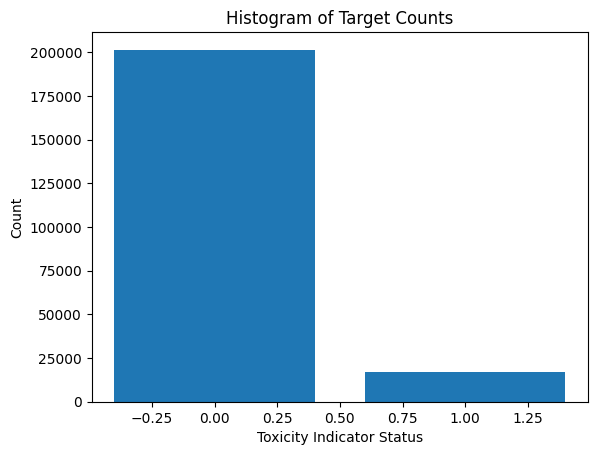

In [ ]:
category_counts = df['toxic_ind'].value_counts()
# Create the histogram
plt.bar(category_counts.index, category_counts.values)
# Add labels and title
plt.xlabel('Toxicity Indicator Status')
plt.ylabel('Count')
plt.title('Histogram of Target Counts')
# Show the plot
plt.show()

The dataset is highly imbalanced. I'll have to take that into consideration when it comes time to pick my evaluation metric.

I noticed this "rating" column which seems like it might be an evaluation of the toxicity rating. I reviewed the data documentation and didn't see this column mentioned. Taking a closer look.

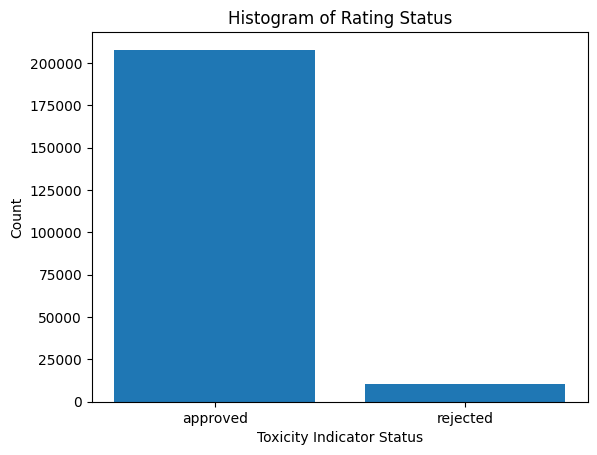

In [ ]:
category_counts = df['rating'].value_counts()
# Create the histogram
plt.bar(category_counts.index, category_counts.values)
# Add labels and title
plt.xlabel('Toxicity Indicator Status')
plt.ylabel('Count')
plt.title('Histogram of Rating Status')
# Show the plot
plt.show()

In [ ]:
# Are a lot of the rejected ratings also identified as being toxic?
len(df.loc[(df['rating'] == 'rejected') & (df['toxic_ind'] == 1)])

# A higher proportion of toxic comments do have this rejected rating

3082

In [ ]:
# Took a look at some example using the head function
# All the comments I reviewed do seem truly toxic so I'm not sure what role the
# rating field plays. Won't exclude based on this field for now.

# df.loc[(df['rating'] == 'rejected') & (df['toxic_ind'] == 1)].head(20)

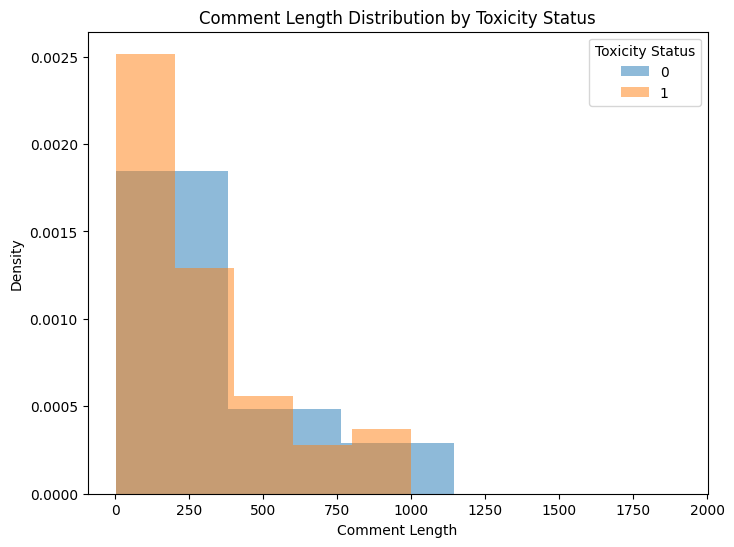

In [ ]:
df['comment_len'] = df['comment_text'].apply(len)
grouped = df.groupby('toxic_ind')
# Plot histograms for each category
plt.figure(figsize=(8, 6))
for name, group in grouped:
  plt.hist(group['comment_len'], bins=5, alpha=0.5, label=name, density=True)
plt.xlabel('Comment Length')
plt.ylabel('Density')
plt.title('Comment Length Distribution by Toxicity Status')
plt.legend(title='Toxicity Status')
plt.show()

The first thing I notice is that these comments vary quite a lot in length. It may make sense to filter down to comments of a certain length but that is something I can come back and experiment with.

It makes sense to see a spike of very short, toxic comments. It doesn't take many characters to all-caps an expletive or insult.

#### Exploration takeaways

- Added the toxicity indicator column.
- Optimization metric needs to consider the class imbalance.
- I'm unsure the role that the rating column plays but it seems safe to ignore it.
- Toxic comments do tend to be shorter than non-toxic.
- The comment text is quite messy and doesn't seem to have been cleaned prior.

### Text Cleaning

In [9]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions, hashtags, and special symbols
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming and Lemmatization
    stemmer = SnowballStemmer("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens]

    # Join tokens back to string
    clean_text = ' '.join(tokens)

    # Remove extra whitespace
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text

def process_comments(df):
    df['clean_comment'] = df['comment_text'].astype(str).apply(clean_text)
    return df

In [10]:
df = process_comments(df)

In [9]:
df.loc[:,['comment_text', 'clean_comment']].head(20)

,comment_text,clean_comment
0,"This is so cool. It's like, 'would you want yo...",cool like would want mother read realli great ...
1,Thank you!! This would make my life a lot less...,thank would make life lot less anxieti induc k...
2,This is such an urgent design problem; kudos t...,urgent design problem kudo take impress
3,Is this something I'll be able to install on m...,someth abl instal site releas
4,haha you guys are a bunch of losers.,haha guy bunch loser
5,ur a sh*tty comment.,ur sh tti comment
6,hahahahahahahahhha suck it.,hahahahahahahahhha suck
7,FFFFUUUUUUUUUUUUUUU,ffffuuuuuuuuuuuuuuu
8,The ranchers seem motivated by mostly by greed...,rancher seem motiv most greed one right allow ...
9,It was a great show. Not a combo I'd of expect...,great show combo expect good togeth


### Dataset-specific Encoding

I plan to experiement with encoding during this project. I'll start by deriving the encoding from the dataset but will then move on to use a publically-availabl encoder to assess the difference.

In [11]:
# Utility function for converting pandas to a TF dataset

def pandas_to_dataset(df, text_column, target_column, batch_size=64):
  """Converts a Pandas DataFrame with one text input column + target column
   to a TensorFlow Dataset."""

  texts = df[text_column].values

  if target_column is None:
    dataset = tf.data.Dataset.from_tensor_slices((texts))
  else:
    labels = df[target_column].astype(int).values
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

  dataset = dataset.batch(batch_size)
  return dataset

In [12]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df.toxic_ind)

print(train_df.shape)
print(valid_df.shape)

(208332, 47)
(52084, 47)


In [13]:
train_tf = pandas_to_dataset(train_df, 'clean_comment', 'toxic_ind')
valid_tf = pandas_to_dataset(valid_df, 'clean_comment', 'toxic_ind')

In [14]:
example, label = next(iter(train_tf))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'love mani stoner smoke lot green ick glad live anchorag rather get cancer deal stuff'

Label:  0


In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens=15000)
encoder.adapt(train_tf.map(lambda text, _: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'love mani stoner smoke lot green ick glad live anchorag rather get cancer deal stuff'
encoded:  [ 185   23 6134  727  103 1211    1  769   54  290  302    6 1700  234
  687]
decoded:  love mani stoner smoke lot green [UNK] glad live anchorag rather get cancer deal stuff


### Model Build

I've decided to create an LSTM model to set the baseline for this task. I'm adding in a dropout layer after the dense layer as well as dropout and recurrent dropout during the LSTM layers. These will prevent overfitting. The memory component of the LSTM layers are well-suited to the task of putting words in context with one another to determine whether or not the comment is toxic or not.

I've also chosen to use Binary Focal Crossentropy as the loss function to address the class imbalance. Binary focal crossentropy downweighs easily-classified examples and weighs by the inverse of class frequency, resulting in a greater emphasis on the minority class. This loss function is much more appropriate for this data than simple binary crossentropy.

Additional details: https://blog.dailydoseofds.com/p/focal-loss-vs-binary-cross-entropy

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



# Summary of the model
model.summary()

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryFocalCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy', 'precision', 'recall']
)

# BinaryFocalCrossentropy

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 64)       │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,071,489 (4.09 MB)

 Trainable params: 1,071,489 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
	train_tf,
	epochs=4,
	validation_data=valid_tf,
)

Epoch 1/4
2729/2729 ━━━━━━━━━━━━━━━━━━━━ 2485s 911ms/step - accuracy: 0.9382 - loss: 0.0589 - precision: 0.6944 - recall: 0.3484 - val_accuracy: 0.9479 - val_loss: 0.0395 - val_precision: 0.7310 - val_recall: 0.5141
Epoch 2/4
2729/2729 ━━━━━━━━━━━━━━━━━━━━ 2484s 910ms/step - accuracy: 0.9478 - loss: 0.0382 - precision: 0.7396 - recall: 0.5031 - val_accuracy: 0.9477 - val_loss: 0.0392 - val_precision: 0.7332 - val_recall: 0.5061
Epoch 3/4
2729/2729 ━━━━━━━━━━━━━━━━━━━━ 2481s 909ms/step - accuracy: 0.9496 - loss: 0.0354 - precision: 0.7509 - recall: 0.5230 - val_accuracy: 0.9459 - val_loss: 0.0446 - val_precision: 0.6893 - val_recall: 0.5429
Epoch 4/4
2729/2729 ━━━━━━━━━━━━━━━━━━━━ 2487s 911ms/step - accuracy: 0.9513 - loss: 0.0328 - precision: 0.7574 - recall: 0.5458 - val_accuracy: 0.9407 - val_loss: 0.0471 - val_precision: 0.6195 - val_recall: 0.5976


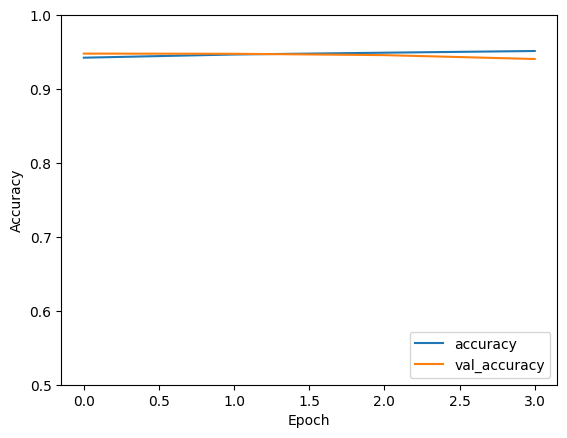

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

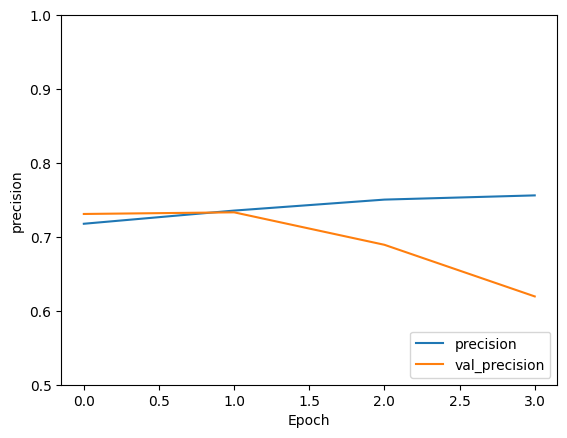

In [ ]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label = 'val_precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

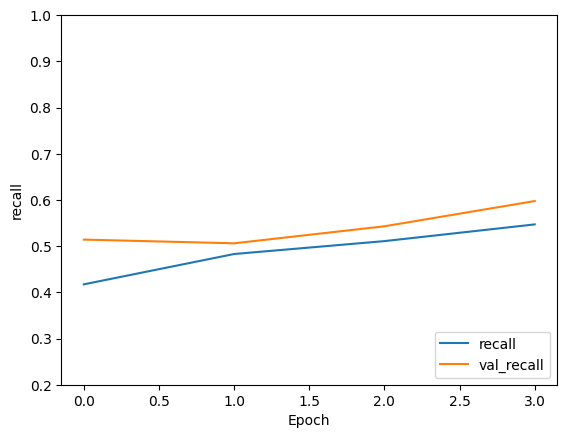

In [ ]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

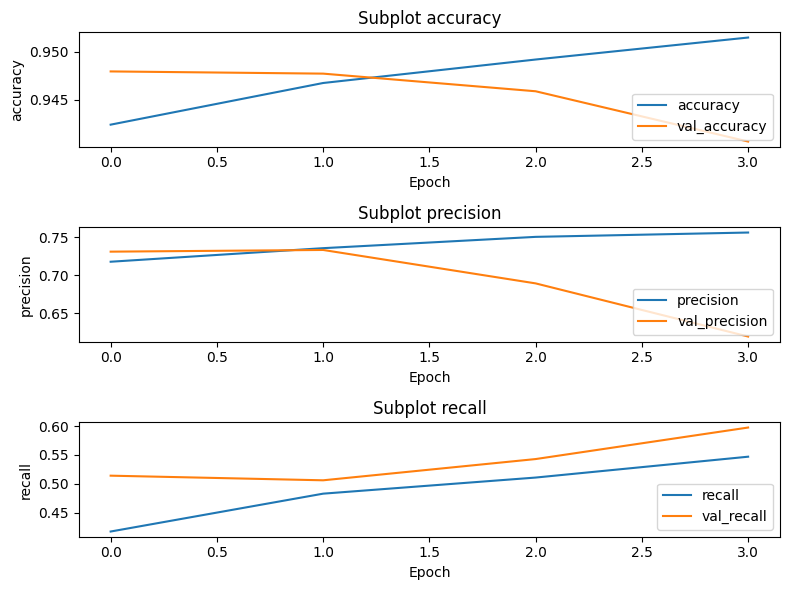

In [ ]:
plot_metrics(history)

The overall performance of the model seems quite strong. Results seem to be best after the second epoch. 73% precision with 51% recall for such a heavily-imbalanced classification task means that a positive prediction represents ~15x risk enhancement. We go from a baseline toxicity rate of ~5% to nearly 75% toxicity among predicted-positive examples.

### Switching to GloVe Embeddings

I would also like to test the performance of the GloVe algorithm. GloVe is an unsupervised algorithm for obtaining vector representations of words.

From the model overview section: "GloVe is essentially a log-bilinear model with a weighted least-squares objective. The main intuition underlying the model is the simple observation that ratios of word-word co-occurrence probabilities have the potential for encoding some form of meaning."

Glove available here: https://nlp.stanford.edu/projects/glove/

In [13]:
MAX_NUM_WORDS = 15000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100       # Must match GloVe dimension (e.g. 50, 100, 200, 300)

# 1. Tokenization and padding
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['clean_comment'])
sequences = tokenizer.texts_to_sequences(df['clean_comment'])

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = df['toxic_ind'].values

Found 52960 unique tokens.


In [14]:
# 2. Load GloVe embeddings
embeddings_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors in GloVe.')

# 3. Create embedding matrix
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors in GloVe.


In [15]:
# 4. Build RNN model with pre-trained embeddings
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
	loss=tf.keras.losses.BinaryFocalCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy', 'precision', 'recall']
)

model.summary()

# 5. Train the model
history = model.fit(X, y, batch_size=32, epochs=5, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 3427s 805ms/step - accuracy: 0.9259 - loss: 0.1139 - precision: 0.0541 - recall: 0.0017 - val_accuracy: 0.9133 - val_loss: 0.0588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 3416s 807ms/step - accuracy: 0.9312 - loss: 0.0519 - precision: 0.5233 - recall: 0.0755 - val_accuracy: 0.9325 - val_loss: 0.0533 - val_precision: 0.7063 - val_recall: 0.3801
Epoch 3/5
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 3393s 802ms/step - accuracy: 0.9422 - loss: 0.0490 - precision: 0.6997 - recall: 0.3522 - val_accuracy: 0.9317 - val_loss: 0.0528 - val_precision: 0.6600 - val_recall: 0.4384
Epoch 4/5
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 3418s 808ms/step - accuracy: 0.9440 - loss: 0.0474 - precision: 0.6960 - recall: 0.3992 - val_accuracy: 0.9308 - val_loss: 0.0523 - val_precision: 0.6248 - val_recall: 0.5048
Epoch 5/5
4232/4232 ━━━━━━━━━━━━━━━━━━━━ 3496s 826ms/step - accuracy: 0.9464 - loss: 0.0461 - precision: 0.7219 - recall: 0.4146

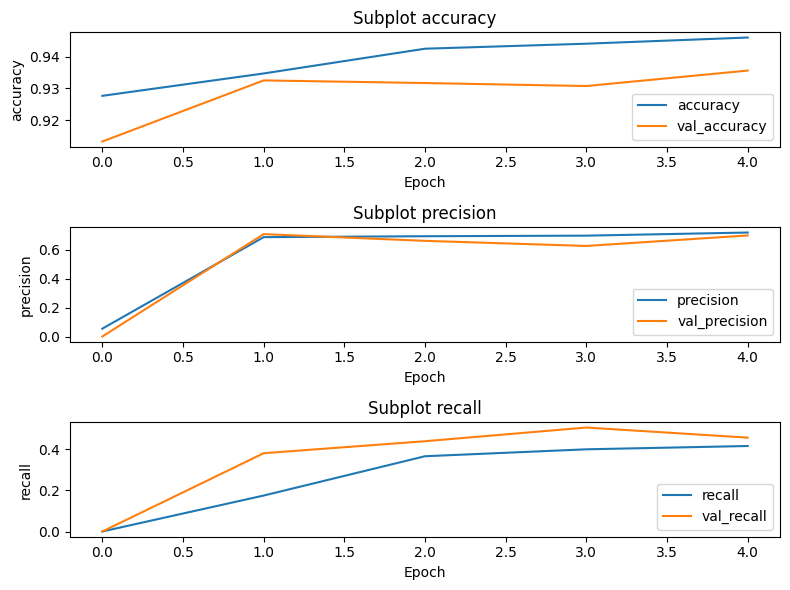

In [16]:
plot_metrics(history)

The model performs similarly when using GloVe for embeddings rather than embadding from scratch. Overall, it seems to perform slightly worse. The GloVe model never has a validation loss lower than 0.05 while the other model has a best validation loss under 0.04. The precision of 0.73 and recall of 0.51 of the original model is also better than the 0.62 / 0.5 validation split of the GloVe model.

### GloVe Text Cleaning Experiment

As I was reading more about GloVe, I came across notes that text cleaning may not always be beneficial to task accuracy. Words with different stem endings can have importantly different meanings and, if possible, it would be great to include that context for the model prediction task. Below, I re-run the model with GloVe embeddings but start with the raw text instead of the clean text.

In [13]:
# Parameters
MAX_NUM_WORDS = 15000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100       # Must match GloVe dimension (e.g. 50, 100, 200, 300)

# 1. Tokenization and padding
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['comment_text'])
sequences = tokenizer.texts_to_sequences(df['comment_text'])

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = df['toxic_ind'].values

Found 157811 unique tokens.


In [14]:
embeddings_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors in GloVe.')

# 3. Create embedding matrix
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors in GloVe.


In [15]:
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2)),

    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
	loss=tf.keras.losses.BinaryFocalCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy', 'precision', 'recall']
)

model.summary()

# 5. Train the model
history = model.fit(X, y, batch_size=32, epochs=5, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8943/8943 ━━━━━━━━━━━━━━━━━━━━ 5006s 558ms/step - accuracy: 0.9234 - loss: 0.0894 - precision: 0.3775 - recall: 0.0453 - val_accuracy: 0.9433 - val_loss: 0.0456 - val_precision: 0.7017 - val_recall: 0.4686
Epoch 2/5
8943/8943 ━━━━━━━━━━━━━━━━━━━━ 5001s 559ms/step - accuracy: 0.9393 - loss: 0.0486 - precision: 0.6881 - recall: 0.4176 - val_accuracy: 0.9470 - val_loss: 0.0421 - val_precision: 0.7155 - val_recall: 0.5278
Epoch 3/5
8943/8943 ━━━━━━━━━━━━━━━━━━━━ 5017s 561ms/step - accuracy: 0.9424 - loss: 0.0455 - precision: 0.7034 - recall: 0.4690 - val_accuracy: 0.9325 - val_loss: 0.0447 - val_precision: 0.5516 - val_recall: 0.6993
Epoch 4/5
8943/8943 ━━━━━━━━━━━━━━━━━━━━ 5028s 562ms/step - accuracy: 0.9434 - loss: 0.0446 - precision: 0.7043 - recall: 0.4886 - val_accuracy: 0.9484 - val_loss: 0.0403 - val_precision: 0.7197 - val_recall: 0.5490
Epoch 5/5
8943/8943 ━━━━━━━━━━━━━━━━━━━━ 5010s 560ms/step - accuracy: 0.9457 - loss: 0.0433 - precision: 0.7264 - recall: 0.4933 - val_a

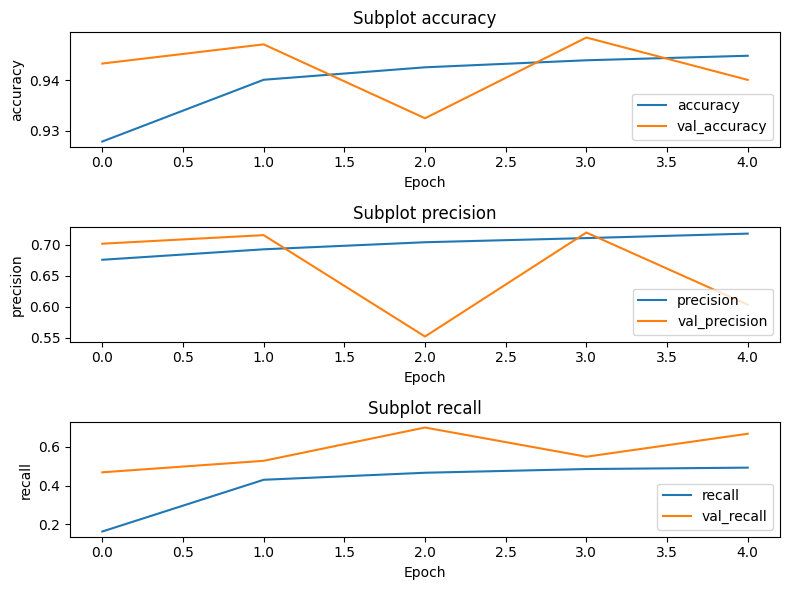

In [16]:
plot_metrics(history)

Using GloVe embeddings on the raw comment text performs better than using the embeddings on cleaned text. The performance of this second GloVe model achieved a best validation result of 72% precision, 55% recall.This is very similar to the best results achieved by the naive-embedding model built on cleaned text. This model clearly outperformed the GloVe model built on cleaned text.

On this uncleaned text, the vocab tripled to ~150,000 unique tokens compared to ~55,000 unique tokens on the cleaned data. This uncleaned version took ~5,000 per epoch compared to ~3,400 seconds per epoch of the cleaned version.

### GRU Model Experiment

Since the GloVe models don't offer a clear performance boost for this task, I decided to assess the performance of using Gated Recurrent Units rather than LSTM units. GRU is a simpler architecture and is appropriate when the task doesn't require memory for long sequences. I believe these comments are short enought that model performance won't be negatively affected by this switch. I tried to keep all other architecture components consistent with prior models.

In [16]:
model = tf.keras.Sequential([
	tf.keras.Input(shape=(1,), dtype=tf.string),
  encoder,
	tf.keras.layers.Embedding(
		len(encoder.get_vocabulary()), 64, mask_zero=True),
	tf.keras.layers.GRU(units=64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    tf.keras.layers.GRU(units=32, dropout=0.3, recurrent_dropout=0.2),
	tf.keras.layers.Dense(64, activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dropout(0.4),
	tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

# Compile the model
model.compile(
	loss=tf.keras.losses.BinaryFocalCrossentropy(),
	optimizer=tf.keras.optimizers.Adam(),
	metrics=['accuracy', 'precision', 'recall']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 64)       │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,545 (3.80 MB)

 Trainable params: 996,545 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
	train_tf,
	epochs=4,
	validation_data=valid_tf,
)

Epoch 1/4
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 1487s 454ms/step - accuracy: 0.9306 - loss: 0.1029 - precision: 0.6007 - recall: 0.2530 - val_accuracy: 0.9455 - val_loss: 0.0402 - val_precision: 0.8102 - val_recall: 0.3915
Epoch 2/4
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 1503s 462ms/step - accuracy: 0.9450 - loss: 0.0394 - precision: 0.7276 - recall: 0.4763 - val_accuracy: 0.9465 - val_loss: 0.0394 - val_precision: 0.7814 - val_recall: 0.4344
Epoch 3/4
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 1495s 459ms/step - accuracy: 0.9477 - loss: 0.0360 - precision: 0.7339 - recall: 0.5224 - val_accuracy: 0.9454 - val_loss: 0.0415 - val_precision: 0.7386 - val_recall: 0.4618
Epoch 4/4
3256/3256 ━━━━━━━━━━━━━━━━━━━━ 1495s 459ms/step - accuracy: 0.9513 - loss: 0.0328 - precision: 0.7476 - recall: 0.5707 - val_accuracy: 0.9406 - val_loss: 0.0473 - val_precision: 0.6453 - val_recall: 0.5266


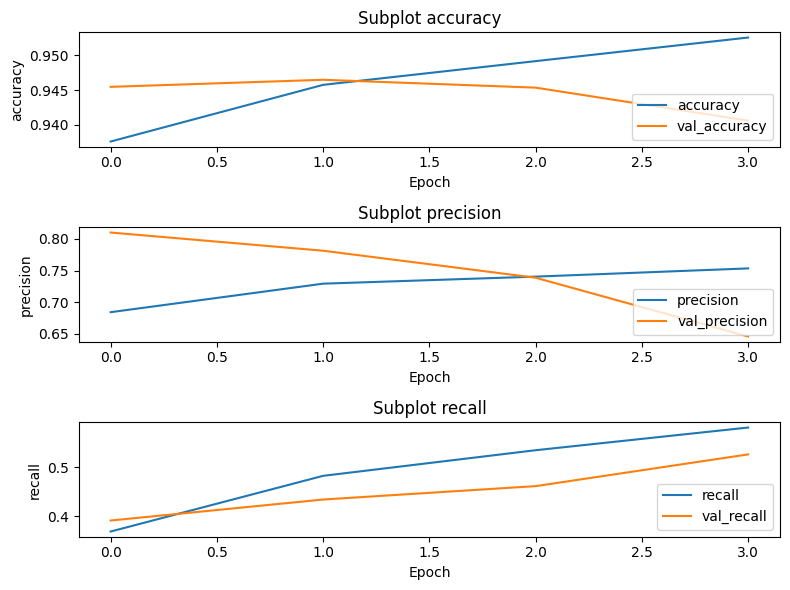

In [18]:
plot_metrics(history)

The GRU model performs very similarly to the other top models that I've used for this dataset - the first LSTM model and second GloVe model. Its best epoch results in 78% precision and 43% recall. Notably, this GRU model trains much faster than the other top models. Each epoch takes ~1,500 seconds compared to ~2,400 seconds for the LSTM model.

### Results Summary

All the models that I tried performed quite well on this classification task. RNN architectures like the ones I worked with here are well-suited to the task of classification based on text. My optimization metrics choice of binary focal crossentropy also contributed to the performance of the models, I believe.

Between the tested models, I saw small but noticeable differences in model performance. There were larger differences in model training time. Comparing between these for models, it seems that simpler is better.

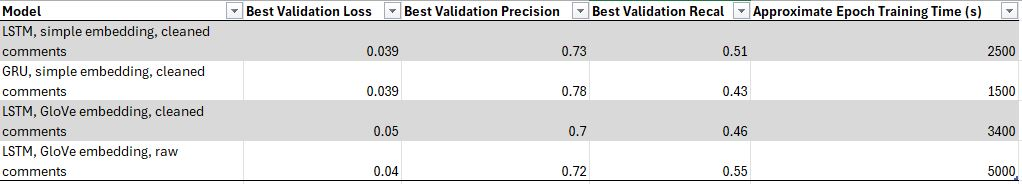

### Discussion and Conclusion

As mentioned in the results section, more complex models and embedding approaches didn't pay off for this prediction task. All models performed well on the task with the simpler approaches having slightly higher performance and much faster training times.

This dataset seems very well-suited to this type of learning and experimentation. There are over 200,000 training examples meaning that the dataset is large enough to benefit from an RNN approach.

Comparing the two GloVe-embedded models, the one that took raw text as an input performed better than the model built on cleaned comments. This isn't too surprising as the other analyses have deomonstrated that the effectiveness of text cleaning prior to GloVe embedding is task dependent.

This dataset could be used for many other machine learning tasks. There are mulitple classes of toxic comments that have been annotated. Those could be used as a multi-class classification problem. In addition, there are columns identifying whether the comments pertain to certain identity groups. The Kaggle competition calls for competitors to use those comments to reduce false positive flags for the mere mention of identity-based words.

This was a helpful learning experience as I had a chance to implement GloVe embeddings for the first time and practice classification based on text. This project was also interesting for the training time v. model performance considerations that it presented. In many of my other projects, differences in training time haven't been as pronounced as what I saw in this project.